In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import wandb
import seaborn as sns

In [2]:
from keras.datasets import fashion_mnist


In [3]:
(X,Y),(X_test,Y_test) = fashion_mnist.load_data()

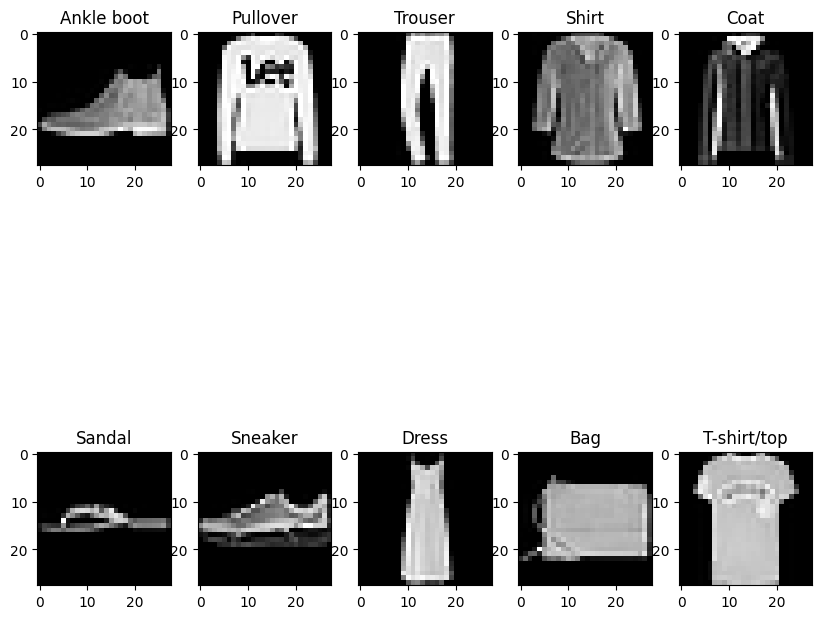

In [4]:
visited_label = []
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fig,axes = plt.subplots(2,5,figsize=(10,10))
axes = axes.flatten()
index = 0
for x in range(len(X_test)):
    if(Y_test[x] not in visited_label):
        visited_label.append(Y_test[x])
        axes[index].imshow(X_test[x],cmap = plt.cm.gray)
        axes[index].set_title("{}".format(class_names[Y_test[x]]))
        index += 1
plt.show()
        



In [5]:
X = X.reshape(len(X),784,1)
X[0].shape
X_test = X_test.reshape(len(X_test),784,1)
X_test[0].shape



(784, 1)

In [6]:
# def fitStandarization(x):
#         mean=np.mean(x,axis=0)
#         var=np.var(x,axis=0)
#         sd=np.sqrt(var)
#         for i in range(x.shape[1]):
#             x[:,i]= x[:,i]-mean[i]
#             x[:,i]=x[:,i]/sd[i]
#         return x

In [7]:
X = X/255.0
X_test = X_test/255.0

In [8]:
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.1,random_state=42)

In [9]:

# X_train = fitStandarization(X_train)
# X_test = fitStandarization(X_test)
# X_val = fitStandarization(X_val)

In [10]:
X_train.shape

(54000, 784, 1)

In [11]:
class NeuralNetwork:
    def __init__(self,optimizer='nadam',batchsize=32,no_of_features = 784,no_of_classes = 10,no_of_layers=5,no_of_neurons_in_each_layer = [128,128,128],max_epochs = 10,eta = 0.001,initialization_method = 'he',activation_method = 'relu',loss = 'cross',weight_decay = 0.001):
        self.optimizer  = optimizer
        self.batchsize = batchsize
        self.no_of_features = no_of_features
        self.no_of_classes = no_of_classes
        self.no_of_layers = no_of_layers
        self.no_of_neurons_in_each_layer = no_of_neurons_in_each_layer
        self.max_epochs = max_epochs
        self.eta = eta
        self.initialization = initialization_method
        self.initialization_list = {'xavier':self.xavier_initialization,'uniform':self.uniform_initialization,'normal':self.normal_initialization,'he':self.he_initialization}
        self.activation = activation_method
        self.activation_list = {'sigmoid':self.sigmoid,'relu':self.Relu,'tanh':self.tanh}
        self.activation_derivative = {'sigmoid':self.sigmoid_derivative,'relu':self.Relu_derivative,'tanh':self.tanh_derivative}
        self.loss = loss
        self.thetas = {}
        self.loss_list = []
        self.weight_decay = weight_decay
    def one_hot(self,l,no_of_classes):
        temp = np.array([0]*no_of_classes)
        temp[l] = 1
        return temp
    def sigmoid(self,x):
        return 1. / (1.+np.exp(-x))

    def sigmoid_derivative(self,x):
        return self.sigmoid(x) * (np.ones_like(x)-self.sigmoid(x))

    def Relu(self,x):
        for i in range(len(x)):
            x[i] = x[i] / max(x[i])
        return np.maximum(0,x)

    def Relu_derivative(self,x):
        # for i in range(len(x)):
        #     x[i] = x[i] / max(x[i])
        return 1*(x>0) 

    def tanh(self,x):
        # for i in range(len(x)):
        #     x[i] = x[i] / max(x[i])
        return np.tanh(x)

    def tanh_derivative(self,x):
        # for i in range(len(x)):
        #     x[i] = x[i] / max(x[i])
        return (1 - (np.tanh(x)**2))

    def softmax(self,x):
        # for i in range(len(x)):
        #     x[i] = x[i] / max(x[i])
        l = []
        for i in range(len(x)):
            l.append(np.exp(x[i])/np.sum(np.exp(x[i]),axis=0))
        return np.array(l)
        
    def softmax_derivative(self,x):
        for i in range(len(x)):
            x[i] = x[i] / max(x[i])
        return self.softmax(x) * (1-self.softmax(x))

    def he_initialization(self):
        np.random.seed(42)
        thetas = {}
        for layer in range(1,self.no_of_layers):
            if(layer == 1):
                thetas['W'+str(layer)] = np.random.normal(0,1,size = (self.no_of_neurons_in_each_layer[layer-1],self.no_of_features)) * np.sqrt(2/(self.no_of_neurons_in_each_layer[layer-1]))
                thetas['b'+str(layer)] = np.random.normal(0,1,size = (self.no_of_neurons_in_each_layer[layer-1],1))*np.sqrt(2/self.no_of_neurons_in_each_layer[layer-1])
            elif(layer == self.no_of_layers-1):
                thetas['W'+str(layer)] = np.random.normal(0,1,size = (self.no_of_classes,self.no_of_neurons_in_each_layer[layer-2])) * np.sqrt(2/(self.no_of_classes))
                thetas['b'+str(layer)] = np.random.normal(0,1,size = (self.no_of_classes,1)) * np.sqrt(2/(self.no_of_classes))
            else:
                thetas['W'+str(layer)] = np.random.normal(0,1,size = (self.no_of_neurons_in_each_layer[layer-1],self.no_of_neurons_in_each_layer[layer-2])) * np.sqrt(2/(self.no_of_neurons_in_each_layer[layer-1]))
                thetas['b'+str(layer)] = np.random.normal(0,1,size = (self.no_of_neurons_in_each_layer[layer-1],1)) * np.sqrt(2/self.no_of_neurons_in_each_layer[layer-1])
        return thetas

    def xavier_initialization(self):
        np.random.seed(42)
        thetas = {}
        for layer in range(1,self.no_of_layers):
            if(layer == 1):
                thetas['W'+str(layer)] = np.random.randn(self.no_of_neurons_in_each_layer[layer-1],self.no_of_features) * np.sqrt(2/(self.no_of_neurons_in_each_layer[layer-1]+self.no_of_features))
                thetas['b'+str(layer)] = np.zeros((self.no_of_neurons_in_each_layer[layer-1],1))
            elif(layer == self.no_of_layers-1):
                thetas['W'+str(layer)] = np.random.randn(self.no_of_classes,self.no_of_neurons_in_each_layer[layer-2]) * np.sqrt(2/(self.no_of_classes + self.no_of_neurons_in_each_layer[layer-2]))
                thetas['b'+str(layer)] = np.zeros((self.no_of_classes,1))
            else:
                # print(layer)
                # print(self.no_of_neurons_in_each_layer[layer-1])
                # print(self.no_of_neurons_in_each_layer[layer-2])
                thetas['W'+str(layer)] = np.random.randn(self.no_of_neurons_in_each_layer[layer-1],self.no_of_neurons_in_each_layer[layer-2]) * np.sqrt(2/(self.no_of_neurons_in_each_layer[layer-1]+self.no_of_neurons_in_each_layer[layer-2]))
                thetas['b'+str(layer)] = np.zeros((self.no_of_neurons_in_each_layer[layer-1],1))
        return thetas

    def uniform_initialization(self):
        thetas = {}
        np.random.seed(42)
        for layer in range(1,self.no_of_layers):
            if(layer == 1):
                thetas['W'+str(layer)] = np.random.default_rng().uniform(low = -0.7,high =0.7,size = (self.no_of_neurons_in_each_layer[layer-1],self.no_of_features)) #* np.sqrt(2/(no_of_neurons_in_each_layer[layer-1]+no_of_features))
                thetas['b'+str(layer)] = np.random.default_rng().uniform(low = -0.7,high =0.7,size = (self.no_of_neurons_in_each_layer[layer-1],1))
            elif(layer == self.no_of_layers-1):
                thetas['W'+str(layer)] = np.random.default_rng().uniform(low = -0.7,high =0.7,size = (self.no_of_classes,self.no_of_neurons_in_each_layer[layer-2])) #* np.sqrt(2/(no_of_classes + no_of_neurons_in_each_layer[layer-2]))
                thetas['b'+str(layer)] = np.random.default_rng().uniform(low = -0.7,high =0.7,size = (self.no_of_classes,1))
            else:
                thetas['W'+str(layer)] = np.random.default_rng().uniform(low = -0.7,high =0.7,size =(self.no_of_neurons_in_each_layer[layer-1],self.no_of_neurons_in_each_layer[layer-2])) #*  np.sqrt(2/(no_of_neurons_in_each_layer[layer-1]+no_of_neurons_in_each_layer[layer-2]))
                thetas['b'+str(layer)] = np.random.default_rng().uniform(low = -0.7,high =0.7,size = (self.no_of_neurons_in_each_layer[layer-1],1))
        return thetas

    def normal_initialization(self):
        thetas = {}
        np.random.seed(42)
        for layer in range(1,self.no_of_layers):
            if(layer == 1):
                thetas['W'+str(layer)] = np.random.uniform(low = -0.7,high =0.7,size = (self.no_of_neurons_in_each_layer[layer-1],self.no_of_features)) #* np.sqrt(2/(no_of_neurons_in_each_layer[layer-1]+no_of_features))
                thetas['b'+str(layer)] = np.zeros((self.no_of_neurons_in_each_layer[layer-1],1))
            elif(layer == self.no_of_layers-1):
                thetas['W'+str(layer)] = np.random.uniform(low = -0.7,high =0.7,size = (self.no_of_classes,self.no_of_neurons_in_each_layer[layer-2])) #* np.sqrt(2/(no_of_classes + no_of_neurons_in_each_layer[layer-2]))
                thetas['b'+str(layer)] = np.zeros((self.no_of_classes,1))
            else:
                thetas['W'+str(layer)] = np.random.uniform(low = -0.7,high =0.7,size =(self.no_of_neurons_in_each_layer[layer-1],self.no_of_neurons_in_each_layer[layer-2])) #*  np.sqrt(2/(no_of_neurons_in_each_layer[layer-1]+no_of_neurons_in_each_layer[layer-2]))
                thetas['b'+str(layer)] = np.zeros((self.no_of_neurons_in_each_layer[layer-1],1))
        return thetas

    def feed_forward(self,data,thetas,layers):
        pre_activation = [1]*(layers)
        activation  = [1]*(layers)
        activation[0] = data
        for layer_no in range(1,layers):
            W = 'W' + str(layer_no)
            b = 'b' + str(layer_no)
            pre_activation[layer_no] = np.add(np.matmul(thetas[W],activation[layer_no - 1]),thetas[b])
            if(layer_no == layers-1):
                activation[layer_no] = self.softmax(pre_activation[layer_no])
            else:
                activation[layer_no] = self.activation_list[self.activation](pre_activation[layer_no])
        return activation,pre_activation

    def back_propagate(self,h,a,thetas,Y):
        grads = {}
        for x in thetas.keys():
            grads[x] = 0
        for x in range(len(Y)):
            temp = h[-1][x] - self.one_hot(Y[x],self.no_of_classes).reshape(self.no_of_classes,1)
            for k in range(self.no_of_layers-1,0,-1):
                W = 'W' + str(k)
                b = 'b' + str(k)
                grads[W] += np.matmul(temp,h[k-1][x].T)/self.batchsize
                grads[b] += temp/self.batchsize
                if(k == 1):
                    break
                temp = np.matmul(thetas[W].T,temp)
                temp = np.multiply(temp,self.activation_derivative[self.activation](a[k-1][x]))
        return grads

    def momentumUpdate(self,t,maxm=.999):
        x=np.log(np.floor(t/250)+1)/np.log(2)
        x=1-2**(-1-x)
        return min(x,maxm)

    def getGamma(self,epoch):
        x=np.log((epoch/250)+1)
        x=-1-1*(x)
        x=2**x
        x=1-x
        return min(x,.9)

    def fit(self,X_train,Y_train):
        self.thetas = self.initialization_list[self.initialization]()
        delta = 1e-9
        grads = {}
        for i in self.thetas.keys():
            grads[i] = 0
        for t in range(self.max_epochs):
            #previous_update
            ut = {}
            vt = {}
            gamma = self.getGamma(t+1)
            beta = self.momentumUpdate(t+1)
            for i in self.thetas.keys():
                ut[i] = 0
                vt[i] = 0
            params_look_ahead = {}
            step = 1
            for x in range(0,X_train.shape[0],self.batchsize):
                beta1 = 0.9#self.momentumUpdate(step)
                beta2 = 0.99#self.momentumUpdate(step)
                if(self.optimizer == 'nesterov'):
                    for i in self.thetas.keys():
                        params_look_ahead[i] = self.thetas[i] - beta1*ut[i]
                    activation,preactivation = self.feed_forward(X_train[x:x+self.batchsize],self.thetas,self.no_of_layers)
                    grads = self.back_propagate(activation,preactivation,params_look_ahead,Y_train[x:x+self.batchsize])
                    for i in self.thetas.keys():
                        ut[i] = beta1*ut[i] + (1-beta1)*grads[i]
                        self.thetas[i] = self.thetas[i] - self.eta*ut[i] - self.eta*self.weight_decay*self.thetas[i]
                elif(self.optimizer == 'mgd'):
                    activation,preactivation = self.feed_forward(X_train[x:x+self.batchsize],self.thetas,self.no_of_layers)
                    grads = self.back_propagate(activation,preactivation,self.thetas,Y_train[x:x+self.batchsize])     
                    for i in self.thetas.keys():
                        ut[i] = gamma*ut[i] + grads[i]
                        self.thetas[i] = self.thetas[i] - self.eta*ut[i] - self.eta*self.weight_decay*self.thetas[i]
                elif(self.optimizer == 'sgd'):
                    activation,preactivation = self.feed_forward(X_train[x:x+self.batchsize],self.thetas,self.no_of_layers)
                    grads = self.back_propagate(activation,preactivation,self.thetas,Y_train[x:x+self.batchsize])
                    for i in self.thetas.keys():
                        self.thetas[i] = self.thetas[i] - self.eta*grads[i] - self.eta*self.weight_decay*self.thetas[i]
                elif(self.optimizer == 'RMSprop'):
                    activation,preactivation = self.feed_forward(X_train[x:x+self.batchsize],self.thetas,self.no_of_layers)
                    grads = self.back_propagate(activation,preactivation,self.thetas,Y_train[x:x+self.batchsize])
                    for i in self.thetas.keys():
                        ut[i] = beta*ut[i] + (1-beta)*np.multiply(grads[i],grads[i])
                        self.thetas[i] = self.thetas[i] - self.eta*grads[i]/((np.sqrt(ut[i])+delta)) - self.eta*self.weight_decay*self.thetas[i]
                elif(self.optimizer == 'adam'):
                    activation,preactivation = self.feed_forward(X_train[x:x+self.batchsize],self.thetas,self.no_of_layers)
                    grads = self.back_propagate(activation,preactivation,self.thetas,Y_train[x:x+self.batchsize])
                    for i in self.thetas.keys():
                        ut[i] = beta1*ut[i] + (1-beta1)*grads[i]
                        uthat = ut[i]/(1 - pow(beta1,t+1))
                        vt[i] = beta2*vt[i] + (1-beta2)*np.multiply(grads[i],grads[i])
                        vthat = vt[i]/(1 - pow(beta2,t+1))
                        self.thetas[i] = self.thetas[i] - self.eta*uthat/((np.sqrt(vthat) + delta)) - self.eta*self.weight_decay*self.thetas[i]
                elif(self.optimizer == 'nadam'):
                    activation,preactivation = self.feed_forward(X_train[x:x+self.batchsize],self.thetas,self.no_of_layers)
                    grads = self.back_propagate(activation,preactivation,self.thetas,Y_train[x:x+self.batchsize])
                    for i in self.thetas.keys():
                        ut[i] = beta1*ut[i] + (1-beta1)*grads[i]
                        uthat = ut[i]/(1 - pow(beta1,t+1))
                        vt[i] = beta2*vt[i] + (1-beta2)*np.multiply(grads[i],grads[i])
                        vthat = vt[i]/(1 - pow(beta2,t+1))
                        self.thetas[i] = self.thetas[i] - (self.eta*(beta1*uthat + (1-beta1)*grads[i]/(1-pow(beta1,t+1))))/(np.sqrt(vthat) + delta) - self.eta*self.weight_decay*self.thetas[i]
                step+=1
            yhat = self.predict(X_train)
            training_accuracy = self.accuracy_score(Y_train,yhat)
            # print(training_accuracy)
            training_loss = self.calculateLoss(yhat,Y_train)
            # print(training_loss)
            self.loss_list.append(training_loss)
            yhat = self.predict(X_val)
            validation_accuracy = self.accuracy_score(Y_val,yhat)
            # print(validation_accuracy)
            validation_loss = self.calculateLoss(yhat,Y_val)
            # print(validation_loss)
            wandb.log({'training_accuracy' : training_accuracy, 'validation_accuracy' : validation_accuracy,'training_loss' : training_loss, 'validation_loss' : validation_loss,'epoch':t+1})
                
    def predict(self,X):
            activation,preactivation = self.feed_forward(X[:],self.thetas,self.no_of_layers)
            return activation[-1]

    def accuracy_score(self,Y,yhat):
        correct = 0
        for x in range(len(yhat)):
            if(np.argmax(yhat[x]) == Y[x]):
                correct+=1
        return (correct/len(Y)*100)
    def calculateLoss(self,yHat,yBatch):
        loss=0
        l2=0
        if(self.loss == 'cross'):
            for x in range(len(yHat)):
                loss += (-1)*np.log(yHat[x][yBatch[x]] + 1e-9)
            for x in self.thetas.keys():
                l2 += np.linalg.norm(self.thetas[x])
            l2 = (self.weight_decay*l2)/2
            return (loss + l2)/len(yHat)
        if(self.loss == 'mse'):
                error = (yHat-yBatch)
                error=error**2
                loss = np.sum(error,axis=0) 
                loss = np.sum(error)  
                loss = loss/2
        return loss

        
        
        

    
    

In [12]:
# NN = NeuralNetwork('nadam',16,784,10,4,[128,128],10,0.002,'he','relu','cross',0.0005)
# NN.fit(X_train,Y_train)
# yhat = NN.predict(X_train)
# print(NN.accuracy_score(Y_train,yhat))
# yhat = NN.predict(X_test)
# print(NN.accuracy_score(Y_test,yhat))
# yhat = NN.predict(X_val)
# print(NN.accuracy_score(Y_val,yhat))

In [13]:
def main():
    wandb.init(project='CS6910_DL_assignment_1')
    config = wandb.config
    wandb.run.name = "op_{}_lr_{}_batch_{}_act_{}_layer_{}_neuron_{}".format(config.optimizer ,config.eta,config.batchsize,config.activation,config.no_of_layers-2,config.no_of_neurons)
    NN = NeuralNetwork(optimizer=config['optimizer'],batchsize=config['batchsize'],no_of_features=config['no_of_features'],no_of_classes=config['no_of_classes'],no_of_layers= config['no_of_layers'],no_of_neurons_in_each_layer = (config['no_of_layers']-2)*[config['no_of_neurons']],max_epochs=config['max_epochs'],eta = config['eta'],initialization_method=config['initialization'],activation_method=config['activation'],loss=config['loss'],weight_decay=config['weight_decay'])
    NN.fit(X_train,Y_train)

In [19]:
sweep_configuration = {
    'method' : 'bayes',
    'metric' : { 'goal' : 'maximize',
    'name' : 'validation_accuracy'},
    'parameters':{
        'optimizer' : { 'values' : ['sgd','mgd','nesterov','RMSprop','adam','nadam']},
        'batchsize' : { 'values' : [16,32,64,128]},
        'no_of_features' : {'values' : [784]},
        'no_of_classes' : {'values' : [10]},
        'no_of_layers' : { 'values' : [3,4,5,6]},
        'no_of_neurons' : {'values' : [32,64,128]},
        'max_epochs' : {'values' : [5,10]},
        'eta' : { 'values' : [1e-1,1e-3,1e-4]},
        'initialization' : { 'values' :['xavier','he','normal','uniform']},
        'activation' : { 'values' : ['sigmoid','relu','tanh']},
        'loss' : { 'values' : ['cross']},
        'weight_decay'  : { 'values' : [0,0.0005,0.001]}
    }
}
sweep_id = wandb.sweep(sweep = sweep_configuration,project = 'CS6910_DL_assignment_1')
wandb.agent(sweep_id,function=main,count = 50)

Create sweep with ID: 7j3ckghm
Sweep URL: https://wandb.ai/cs22m031/CS6910_DL_assignment_1/sweeps/7j3ckghm


wandb: Agent Starting Run: t8b5j5mt with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 16
wandb: 	eta: 0.0001
wandb: 	initialization: uniform
wandb: 	loss: cross
wandb: 	max_epochs: 5
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 3
wandb: 	no_of_neurons: 128
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,█▅▃▂▁
validation_accuracy,▁▄▆▇█
validation_loss,█▅▃▂▁
epoch,5
training_accuracy,56.07037
training_loss,1.32495
validation_accuracy,56.13333
validation_loss,1.33895


wandb: Agent Starting Run: ansl398j with config:
wandb: 	activation: relu
wandb: 	batchsize: 64
wandb: 	eta: 0.001
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 5
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 3
wandb: 	no_of_neurons: 32
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▃▅▆█
training_accuracy,▁▅▇▇█
training_loss,█▆▄▂▁
validation_accuracy,▁▅▇██
validation_loss,█▆▄▂▁
epoch,5
training_accuracy,58.1537
training_loss,1.7109
validation_accuracy,57.08333
validation_loss,1.71625


wandb: Agent Starting Run: 0dh4r4vy with config:
wandb: 	activation: relu
wandb: 	batchsize: 64
wandb: 	eta: 0.001
wandb: 	initialization: he
wandb: 	loss: cross
wandb: 	max_epochs: 5
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 32
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▃▅▆█
training_accuracy,▁▄▆▇█
training_loss,█▄▃▂▁
validation_accuracy,▁▃▆▇█
validation_loss,█▄▃▂▁
epoch,5
training_accuracy,72.63148
training_loss,0.75287
validation_accuracy,71.55
validation_loss,0.75398


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2iu3634y with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: he
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 4
wandb: 	no_of_neurons: 128
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▄▃▂▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▇▇▇███
validation_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
training_accuracy,84.54259
training_loss,0.4393
validation_accuracy,83.75
validation_loss,0.44741


wandb: Agent Starting Run: 4rb7703q with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.001
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 32
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▇▇▇▇███
training_loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▆▇▇▇▇███
validation_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
training_accuracy,84.61296
training_loss,0.45953
validation_accuracy,82.81667
validation_loss,0.48757


wandb: Agent Starting Run: 5a7i59hw with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: he
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 4
wandb: 	no_of_neurons: 32
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▆▇▇▇███
training_loss,█▆▄▃▃▂▂▂▁▁
validation_accuracy,▁▄▆▆▇▇▇███
validation_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
training_accuracy,76.98148
training_loss,0.78086
validation_accuracy,76.48333
validation_loss,0.79155


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dtwo2mru with config:
wandb: 	activation: relu
wandb: 	batchsize: 128
wandb: 	eta: 0.001
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 128
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▆▇▇▇██
training_loss,█▅▄▄▃▂▂▂▁▁
validation_accuracy,▁▃▄▅▆▇▇▇██
validation_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
training_accuracy,82.87778
training_loss,0.49413
validation_accuracy,82.23333
validation_loss,0.49763


wandb: Agent Starting Run: 16ojnj6n with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 64
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇▇███
training_loss,█▅▃▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇██
validation_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
training_accuracy,80.34074
training_loss,0.56542
validation_accuracy,79.36667
validation_loss,0.57745


wandb: Agent Starting Run: brwkhq1o with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.1
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 128
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁██████▅▅▅
training_loss,▆▅█▆▃▂▂▁▁▁
validation_accuracy,█▁▁▁▁▁▁▄▄▄
validation_loss,▆▅█▆▃▂▂▁▁▁
epoch,10
training_accuracy,9.98519
training_loss,2.38184
validation_accuracy,10.13333
validation_loss,2.37941


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4y1tg033 with config:
wandb: 	activation: tanh
wandb: 	batchsize: 128
wandb: 	eta: 0.001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 64
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇▇███
training_loss,█▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▄▆▇▇█████
validation_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
training_accuracy,87.31111
training_loss,0.35284
validation_accuracy,83.11667
validation_loss,0.45443


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8s1pbaub with config:
wandb: 	activation: tanh
wandb: 	batchsize: 128
wandb: 	eta: 0.001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 128
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇▇▇██
training_loss,█▅▄▃▃▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇██
validation_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
training_accuracy,88.57037
training_loss,0.31002
validation_accuracy,84.95
validation_loss,0.43506


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u9w5szul with config:
wandb: 	activation: tanh
wandb: 	batchsize: 64
wandb: 	eta: 0.0001
wandb: 	initialization: uniform
wandb: 	loss: cross
wandb: 	max_epochs: 5
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 64
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▃▅▆█
training_accuracy,▁▅▆▇█
training_loss,█▄▃▂▁
validation_accuracy,▁▅▆▇█
validation_loss,█▄▃▂▁
epoch,5
training_accuracy,75.0
training_loss,0.70216
validation_accuracy,73.08333
validation_loss,0.75508


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: byv0c71q with config:
wandb: 	activation: tanh
wandb: 	batchsize: 64
wandb: 	eta: 0.1
wandb: 	initialization: uniform
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 128
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▁▁▁▁▁▁▁▁█
training_loss,█▂▂▂▁▁▁▁▁▁
validation_accuracy,█████████▁
validation_loss,█▁▂▂▁▁▁▁▁▁
epoch,10
training_accuracy,10.09259
training_loss,2.4852
validation_accuracy,9.16667
validation_loss,2.49568


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4xc55ssu with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.1
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 3
wandb: 	no_of_neurons: 64
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▇▇████
validation_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
training_accuracy,86.44259
training_loss,0.39153
validation_accuracy,85.4
validation_loss,0.40122


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dub2cc9k with config:
wandb: 	activation: relu
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: uniform
wandb: 	loss: cross
wandb: 	max_epochs: 5
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 128
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▃▅▆█
training_accuracy,▁▅▆▇█
training_loss,█▄▂▂▁
validation_accuracy,▁▅▆▇█
validation_loss,█▄▂▂▁
epoch,5
training_accuracy,79.27037
training_loss,0.59453
validation_accuracy,78.66667
validation_loss,0.60033


wandb: Agent Starting Run: j08tc3st with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: he
wandb: 	loss: cross
wandb: 	max_epochs: 5
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 4
wandb: 	no_of_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▃▅▆█
training_accuracy,▁▅▇▇█
training_loss,█▅▃▂▁
validation_accuracy,▁▄▆▇█
validation_loss,█▅▃▂▁
epoch,5
training_accuracy,16.18333
training_loss,2.53843
validation_accuracy,16.55
validation_loss,2.51764


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: otzrucuv with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.1
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 3
wandb: 	no_of_neurons: 32
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▇▇██▆█▇█
training_loss,█▆▄▂▁▁▂▂▁▁
validation_accuracy,▁▄▆▆█▇▆▇▇▇
validation_loss,█▆▄▂▁▂▁▂▁▂
epoch,10
training_accuracy,81.11296
training_loss,0.52416
validation_accuracy,80.05
validation_loss,0.54921


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yjtil20o with config:
wandb: 	activation: relu
wandb: 	batchsize: 128
wandb: 	eta: 0.1
wandb: 	initialization: he
wandb: 	loss: cross
wandb: 	max_epochs: 5
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 128
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▃▅▆█
training_accuracy,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
epoch,5
training_accuracy,10.00556
training_loss,nan
validation_accuracy,9.95
validation_loss,nan


wandb: Agent Starting Run: w242p0rq with config:
wandb: 	activation: relu
wandb: 	batchsize: 128
wandb: 	eta: 0.1
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 4
wandb: 	no_of_neurons: 64
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,█▁▁▁▁▁▁▁▁▁
training_loss,▁
validation_accuracy,█▁▁▁▁▁▁▁▁▁
validation_loss,▁
epoch,10
training_accuracy,10.00556
training_loss,nan
validation_accuracy,9.95
validation_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mljfs846 with config:
wandb: 	activation: tanh
wandb: 	batchsize: 128
wandb: 	eta: 0.001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 64
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▆▆▇▇███
training_loss,█▆▄▃▃▂▂▁▁▁
validation_accuracy,▁▄▅▆▇▇████
validation_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
training_accuracy,87.53519
training_loss,0.34472
validation_accuracy,84.96667
validation_loss,0.41565


wandb: Agent Starting Run: 91w3vnl3 with config:
wandb: 	activation: relu
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: uniform
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 128
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▆██████
training_loss,█▆▆▅▄▄▃▂▂▁
validation_accuracy,▁▃▄▆██████
validation_loss,█▆▆▅▄▄▃▂▂▁
epoch,10
training_accuracy,38.64444
training_loss,2.01535
validation_accuracy,37.43333
validation_loss,2.02104


wandb: Agent Starting Run: mos31ji7 with config:
wandb: 	activation: relu
wandb: 	batchsize: 128
wandb: 	eta: 0.1
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 3
wandb: 	no_of_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇▇██
training_loss,█▅▃▂▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇██
validation_loss,█▅▃▂▂▂▂▁▁▁
epoch,10
training_accuracy,76.41111
training_loss,0.7454
validation_accuracy,76.16667
validation_loss,0.75098


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8bdphhus with config:
wandb: 	activation: relu
wandb: 	batchsize: 128
wandb: 	eta: 0.001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 64
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▆▇▇▇██
training_loss,█▅▄▃▃▂▂▁▁▁
validation_accuracy,▁▃▄▅▆▇▇███
validation_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
training_accuracy,83.28704
training_loss,0.47955
validation_accuracy,82.78333
validation_loss,0.47501


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mwaw02xn with config:
wandb: 	activation: tanh
wandb: 	batchsize: 64
wandb: 	eta: 0.0001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 5
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 32
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▃▅▆█
training_accuracy,▁▅▇▇█
training_loss,█▄▃▂▁
validation_accuracy,▁▅▇▇█
validation_loss,█▄▂▂▁
epoch,5
training_accuracy,74.45926
training_loss,0.70839
validation_accuracy,73.66667
validation_loss,0.72094


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ki8bwpxb with config:
wandb: 	activation: tanh
wandb: 	batchsize: 64
wandb: 	eta: 0.0001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 5
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 128
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▃▅▆█
training_accuracy,▁▅▆▇█
training_loss,█▄▃▂▁
validation_accuracy,▁▅▇▇█
validation_loss,█▄▂▂▁
epoch,5
training_accuracy,77.74444
training_loss,0.65002
validation_accuracy,74.73333
validation_loss,0.72925


wandb: Agent Starting Run: 2ds50wmv with config:
wandb: 	activation: tanh
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 64
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇██
validation_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
training_accuracy,77.81852
training_loss,0.60874
validation_accuracy,76.45
validation_loss,0.65619


wandb: Agent Starting Run: b41gzq52 with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 128
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▄▃▂▂▂▂▁▁▁
validation_accuracy,▁▄▆▇▇▇▇███
validation_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
training_accuracy,84.59074
training_loss,0.43592
validation_accuracy,83.56667
validation_loss,0.44377


wandb: Agent Starting Run: stfl74xa with config:
wandb: 	activation: relu
wandb: 	batchsize: 64
wandb: 	eta: 0.0001
wandb: 	initialization: he
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 128
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▅▆▇▇▇██
training_loss,█▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▃▅▆▆▇▇███
validation_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
training_accuracy,85.82222
training_loss,0.39783
validation_accuracy,84.95
validation_loss,0.40518


wandb: Agent Starting Run: regyerbe with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 32
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▆▇▇▇███
training_loss,█▄▃▂▂▂▂▁▁▁
validation_accuracy,▁▄▆▇▇▇████
validation_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
training_accuracy,86.55185
training_loss,0.38002
validation_accuracy,85.2
validation_loss,0.40853


wandb: Agent Starting Run: kl2d86j4 with config:
wandb: 	activation: tanh
wandb: 	batchsize: 32
wandb: 	eta: 0.0001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 128
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇▇▇██
training_loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▆▆▇▇████
validation_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
training_accuracy,82.84259
training_loss,0.47914
validation_accuracy,78.95
validation_loss,0.58383


wandb: Agent Starting Run: gwlrn2xk with config:
wandb: 	activation: relu
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: uniform
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 32
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅██▇▇▇▇▇▇
training_loss,█▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▅██▇▇▇▇▇▇
validation_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
training_accuracy,57.05185
training_loss,1.37235
validation_accuracy,56.66667
validation_loss,1.37859


wandb: Agent Starting Run: g9g2v863 with config:
wandb: 	activation: relu
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: uniform
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 32
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▆▆▆▆▆▇▇██
training_loss,█▆▅▄▃▂▂▂▁▁
validation_accuracy,▁▆▆▆▆▇▇▇██
validation_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
training_accuracy,60.39444
training_loss,1.18298
validation_accuracy,59.56667
validation_loss,1.19083


wandb: Agent Starting Run: sq90yrr4 with config:
wandb: 	activation: tanh
wandb: 	batchsize: 64
wandb: 	eta: 0.0001
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 128
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇▇▇██
training_loss,█▅▄▄▃▂▂▂▁▁
validation_accuracy,▁▃▄▅▆▆▇▇██
validation_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
training_accuracy,88.22407
training_loss,0.32868
validation_accuracy,87.26667
validation_loss,0.35015


wandb: Agent Starting Run: zugdwvpu with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: uniform
wandb: 	loss: cross
wandb: 	max_epochs: 5
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 32
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▃▅▆█
training_accuracy,▁▆▇██
training_loss,█▆▄▂▁
validation_accuracy,▁▆▇██
validation_loss,█▅▄▂▁
epoch,5
training_accuracy,56.42963
training_loss,1.42268
validation_accuracy,54.85
validation_loss,1.43487


wandb: Agent Starting Run: a6c9nrgg with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 64
wandb: 	eta: 0.0001
wandb: 	initialization: he
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 3
wandb: 	no_of_neurons: 64
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▇▇▇███
validation_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
training_accuracy,84.41852
training_loss,0.45418
validation_accuracy,84.0
validation_loss,0.45494


wandb: Agent Starting Run: 5lnhgp02 with config:
wandb: 	activation: relu
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 32
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,█▄▇▂▁▃▄▆▆▇
training_loss,█▆▅▅▄▃▃▂▁▁
validation_accuracy,█▅▆▂▁▃▅▅▅▆
validation_loss,█▆▅▅▄▃▃▂▁▁
epoch,10
training_accuracy,56.2463
training_loss,1.37566
validation_accuracy,55.33333
validation_loss,1.3806


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t6p1k54w with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 64
wandb: 	eta: 0.0001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 4
wandb: 	no_of_neurons: 32
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▆▆▇▇▇███
training_loss,█▆▄▃▃▂▂▁▁▁
validation_accuracy,▁▄▆▆▇▇▇███
validation_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
training_accuracy,79.05
training_loss,0.6577
validation_accuracy,78.48333
validation_loss,0.67204


wandb: Agent Starting Run: yi2xib6s with config:
wandb: 	activation: tanh
wandb: 	batchsize: 64
wandb: 	eta: 0.0001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 128
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇▇███
training_loss,█▅▃▃▂▂▂▁▁▁
validation_accuracy,▁▅▆▆▇▇▇███
validation_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
training_accuracy,79.70926
training_loss,0.57656
validation_accuracy,73.88333
validation_loss,0.76098


wandb: Agent Starting Run: xsezp2mq with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 32
wandb: 	eta: 0.0001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 4
wandb: 	no_of_neurons: 32
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇▇███
training_loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▇▇███
validation_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
training_accuracy,81.20185
training_loss,0.56016
validation_accuracy,80.31667
validation_loss,0.57496


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9d22kivm with config:
wandb: 	activation: tanh
wandb: 	batchsize: 64
wandb: 	eta: 0.0001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 64
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇▇███
training_loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇██
validation_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
training_accuracy,79.85
training_loss,0.55695
validation_accuracy,77.65
validation_loss,0.6054


wandb: Agent Starting Run: y6fuw8nz with config:
wandb: 	activation: tanh
wandb: 	batchsize: 64
wandb: 	eta: 0.0001
wandb: 	initialization: he
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 64
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇▇▇██
training_loss,█▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▃▅▆▆▇▇▇██
validation_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
training_accuracy,85.98148
training_loss,0.38676
validation_accuracy,85.2
validation_loss,0.40878


wandb: Agent Starting Run: 4ukpi9iw with config:
wandb: 	activation: relu
wandb: 	batchsize: 64
wandb: 	eta: 0.0001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 6
wandb: 	no_of_neurons: 32
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▇▇▇▇████
training_loss,█▆▅▄▃▃▂▂▁▁
validation_accuracy,▁▅▇▇██████
validation_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
training_accuracy,62.52963
training_loss,1.17835
validation_accuracy,61.93333
validation_loss,1.18056


wandb: Agent Starting Run: vtgzwzj2 with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: uniform
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 4
wandb: 	no_of_neurons: 64
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▆▇▇▇████
training_loss,█▅▃▂▂▂▁▁▁▁
validation_accuracy,▁▅▆▇▇▇▇███
validation_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
training_accuracy,81.32037
training_loss,0.55269
validation_accuracy,81.08333
validation_loss,0.55924


wandb: Agent Starting Run: 7z3afzq5 with config:
wandb: 	activation: relu
wandb: 	batchsize: 128
wandb: 	eta: 0.001
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 3
wandb: 	no_of_neurons: 32
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▅▆▆▇▇██
training_loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▃▅▅▆▇▇▇██
validation_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
training_accuracy,77.42778
training_loss,0.62602
validation_accuracy,76.98333
validation_loss,0.63168


wandb: Agent Starting Run: b0d83pwh with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 64
wandb: 	eta: 0.0001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 3
wandb: 	no_of_neurons: 32
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇██
validation_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
training_accuracy,79.96667
training_loss,0.60585
validation_accuracy,79.63333
validation_loss,0.6144


wandb: Agent Starting Run: hr1yx92g with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: he
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 64
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▄▅▆▆▇▇███
training_loss,█▅▄▃▂▂▁▁▁▁
validation_accuracy,▁▄▅▆▆▇▇███
validation_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
training_accuracy,80.86111
training_loss,0.56137
validation_accuracy,80.13333
validation_loss,0.56727


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w73je7ll with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 3
wandb: 	no_of_neurons: 32
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▆▆▇▇▇███
training_loss,█▆▄▃▃▂▂▂▁▁
validation_accuracy,▁▅▆▆▇▇▇███
validation_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
training_accuracy,80.24815
training_loss,0.66011
validation_accuracy,79.33333
validation_loss,0.67142


wandb: Agent Starting Run: g9nhyn9t with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 64
wandb: 	eta: 0.001
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 3
wandb: 	no_of_neurons: 32
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▅▆▆▇▇▇██
training_loss,█▅▄▃▃▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇██
validation_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
training_accuracy,88.15741
training_loss,0.33428
validation_accuracy,87.43333
validation_loss,0.355


wandb: Agent Starting Run: dxpi4dh7 with config:
wandb: 	activation: sigmoid
wandb: 	batchsize: 128
wandb: 	eta: 0.0001
wandb: 	initialization: xavier
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 3
wandb: 	no_of_neurons: 32
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▆▆▇▇▇███
training_loss,█▆▄▃▃▂▂▁▁▁
validation_accuracy,▁▅▆▆▇▇▇███
validation_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
training_accuracy,81.48333
training_loss,0.58581
validation_accuracy,81.06667
validation_loss,0.59468


wandb: Agent Starting Run: 8mkyruwn with config:
wandb: 	activation: relu
wandb: 	batchsize: 32
wandb: 	eta: 0.0001
wandb: 	initialization: normal
wandb: 	loss: cross
wandb: 	max_epochs: 10
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 3
wandb: 	no_of_neurons: 32
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▅▆▆▇▇▇███
training_loss,█▅▄▃▃▂▂▁▁▁
validation_accuracy,▁▅▆▆▇▇▇███
validation_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
training_accuracy,73.27593
training_loss,0.87846
validation_accuracy,72.63333
validation_loss,0.88938


In [14]:
sweep_configuration = {
    'method' : 'random',
    'metric' : { 'goal' : 'maximize',
    'name' : 'validation_accuracy'},
    'parameters':{
        'optimizer' : { 'values' : ['adam','nadam']},
        'batchsize' : { 'values' : [128,256]},
        'no_of_features' : {'values' : [784]},
        'no_of_classes' : {'values' : [10]},
        'no_of_layers' : { 'values' : [5,6]},
        'no_of_neurons' : {'values' : [256,512]},
        'max_epochs' : {'values' : [10,15]},
        'eta' : { 'values' : [0.001,0.002,0.0001]},
        'initialization' : { 'values' :['he']},
        'activation' : { 'values' : ['relu']},
        'loss' : { 'values' : ['cross']},
        'weight_decay'  : { 'values' : [0,0.0005,0.001]}
    }
}
sweep_id = wandb.sweep(sweep = sweep_configuration,project = 'CS6910_DL_assignment_1')
wandb.agent(sweep_id,function=main,count = 20)

Create sweep with ID: naxh06ik
Sweep URL: https://wandb.ai/cs22m031/CS6910_DL_assignment_1/sweeps/naxh06ik


wandb: Agent Starting Run: p3dxlz9m with config:
wandb: 	activation: relu
wandb: 	batchsize: 256
wandb: 	eta: 0.002
wandb: 	initialization: he
wandb: 	loss: cross
wandb: 	max_epochs: 15
wandb: 	no_of_classes: 10
wandb: 	no_of_features: 784
wandb: 	no_of_layers: 5
wandb: 	no_of_neurons: 256
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: Currently logged in as: cs22m031. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
